# Import common modules

In [4]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf 

## Load data and normalize by event

In [5]:
def normalize_events(events):
    events_max = events.max(axis=1, keepdims=True)  # max per event
    return events / events_max

def normalize_truths(truths):
    truths_max = truths.max(axis=(1, 2, 3), keepdims=True)
    return truths / truths_max

with h5py.File('./data/lightweight_dataset_20cm.h5', 'r') as f:
    events = f['inputs'][:]
    truths = f['targets'][:]

X = normalize_events(events)
y = normalize_truths(truths)

## Plots to visualize data
### Histograms for distributions of full dataset, GIF to compare features and thruths event by event

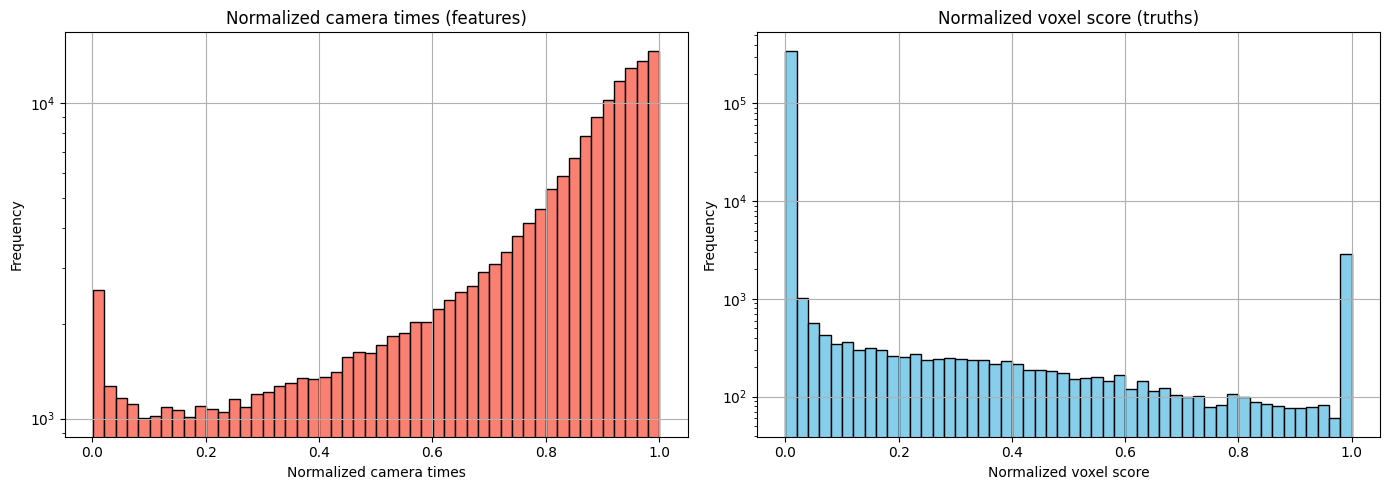

In [6]:
# Check normalization
plt.figure(figsize=(14, 5))

# Histogram of normalized event values (left)
plt.subplot(1, 2, 1)
plt.hist(X.flatten(), bins=50, color='salmon', edgecolor='black', log=True)
plt.xlabel('Normalized camera times')
plt.ylabel('Frequency')
plt.title('Normalized camera times (features)')
plt.grid(True)

# Histogram of normalized truth values (right)
plt.subplot(1, 2, 2)
plt.hist(y.flatten(), bins=50, color='skyblue', edgecolor='black', log=True)
plt.xlabel('Normalized voxel score')
plt.ylabel('Frequency')
plt.title('Normalized voxel score (truths)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Make animation with input and expected output

n_samples = min(10, len(X))  # number of samples to animate

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1)             # Left plot: Camera times (event features)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Right plot: Voxel score plot (truth)

# Prepare event feature line plot
line, = ax1.plot([], [], marker='o')
ax1.set_ylim(0, 1)
ax1.set_xlim(0, X.shape[1])
ax1.set_xlabel('Camera index')
ax1.set_ylabel('Normalized time')
ax1.grid(True)

# Prepare voxel plot color normalization and colormap
cmap = plt.get_cmap('magma')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
mappable = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(mappable, ax=ax2, shrink=0.6, pad=0.1)
cbar.set_label('Normalized score')

def update(frame):
    sample_idx = frame
    truth_sample = y[sample_idx]
    event_features = X[sample_idx]

    # Update line plot (left)
    line.set_data(np.arange(len(event_features)), event_features)
    ax1.set_title(f'Camera times (features) - Event {sample_idx}')

    # Clear and update voxel plot (right)
    ax2.cla()
    normed = truth_sample / truth_sample.max()
    filled = normed > 0.01
    colors = cmap(norm(normed))

    ax2.voxels(filled, facecolors=colors, edgecolor='k', linewidth=0.3)

    ax2.set_xlim([0, y.shape[1]]) 
    ax2.set_ylim([0, y.shape[2]])
    ax2.set_zlim([0, y.shape[3]])

    ax2.set_xlabel('voxel_ID_x')
    ax2.set_ylabel('voxel_ID_y')
    ax2.set_zlabel('voxel_ID_z')
    ax2.set_title(f'Voxel score (truths) - Event {sample_idx}')

    return [line]


ani = animation.FuncAnimation(fig, update, frames=n_samples, interval=1500, blit=False)

plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

## Optimize model hyperparameters with Optuna

In [7]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class MaxNormalize1D(tf.keras.layers.Layer):
    def call(self, inputs):
        max_val = tf.reduce_max(inputs, axis=1, keepdims=True)
        return inputs / (max_val + 1e-6)

In [8]:
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

input_dim = len(X[0])
output_shape = y[0].shape

# Global tracking variables
best_model = None
best_history = None
best_val_loss = float("inf")
best_trial_number = None

# Objective function for OPTUNA
def objective(trial):
    global best_model, best_history, best_val_loss, best_trial_number

    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 1, 4)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))

    for i in range(num_layers):
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(np.prod(output_shape), activation='relu'))
    model.add(MaxNormalize1D())
    model.add(tf.keras.layers.Reshape(output_shape))

    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        verbose=0,
        callbacks=[TFKerasPruningCallback(trial, "val_loss")]
    )

    val_loss = min(history.history["val_loss"])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history.history
        best_trial_number = trial.number

    return val_loss

# Run OPTUNA study

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Best trial

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


/home/filippo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-09-04 11:53:54,703] A new study created in memory with name: no-name-753f5fb8-0db4-4e3c-91f3-c49aba6de514
I0000 00:00:1756979636.049927    7927 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1756979639.202533   15631 service.cc:148] XLA service 0x7fc41801cf70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756979639.202988   15631 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-09-04 11:53:59.274433: I tensorflow/compiler/mlir/tensorflow/utils/du

Best trial:
  Value: 0.011569974943995476
  Params:
    optimizer: rmsprop
    learning_rate: 0.0008497433773784315
    dropout_rate: 0.1420072108972978
    batch_size: 32
    num_layers: 3


## Training history of best model

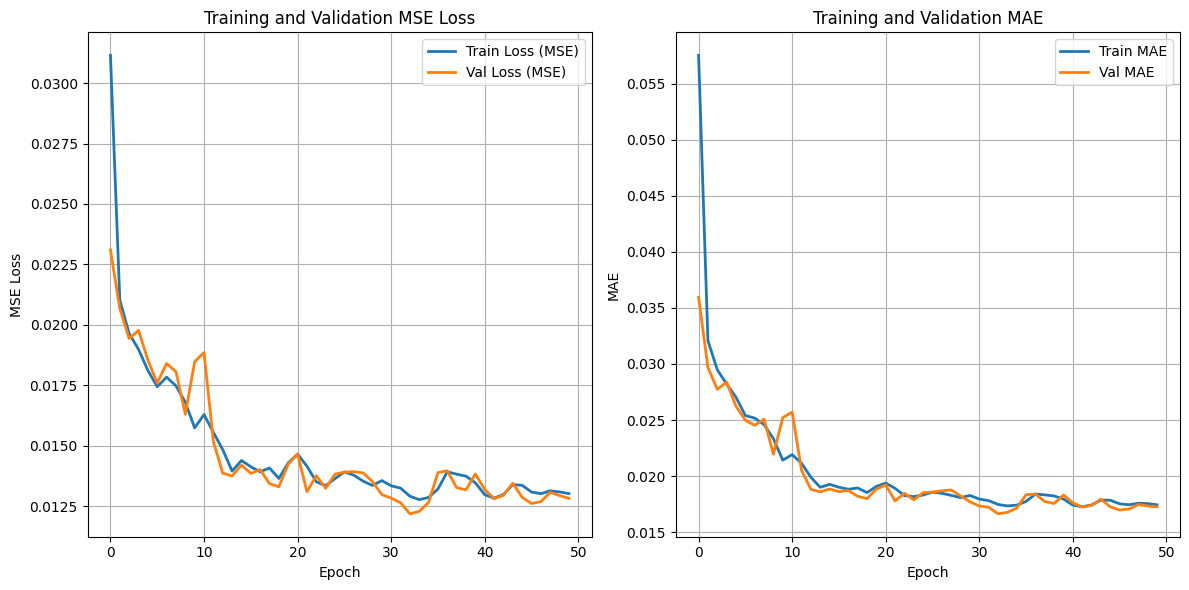

In [ ]:
# Plot MSE and MAE curves
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(best_history['loss'], label='Train Loss (MSE)', lw=2)
plt.plot(best_history['val_loss'], label='Val Loss (MSE)', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(best_history['mae'], label='Train MAE', lw=2)
plt.plot(best_history['val_mae'], label='Val MAE', lw=2)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Save best model

In [ ]:
# Save the trained model to a file
best_model.save('./saved_models/pre_volumereco_optuna_20cm_new.keras')

# Load previously saved model
### Start from here to skip training step

In [9]:
from tensorflow.keras.models import load_model

# Load a previously saved model
model = load_model(
    "./saved_models/pre_volumereco_optuna_20cm.keras",
    custom_objects={"MaxNormalize1D": MaxNormalize1D},
    compile=True,
)

## Compare model predictions with truths
### Visualize 2D slices of the 3D distribution

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
(1, 60) [[0.93489426 0.94791543 0.94565517 0.9349511  0.9400242  0.9434368
  0.9479125  0.94945216 0.97092366 0.9572394  0.9909718  0.967711
  0.9872744  0.8765774  0.8014729  0.98161703 0.9838823  0.990541
  0.99626225 0.99988025 0.05461305 0.24423704 0.8459334  0.6877235
  0.4647542  0.62223566 0.93954366 0.9363785  0.9420906  0.37205288
  0.9356054  0.92072725 0.9767127  0.9705137  0.97847354 0.98566175
  0.99294704 0.9223194  0.91771543 0.94913244 0.9230423  0.9116394
  0.92937833 0.95735896 0.9488765  0.9580307  0.9058364  0.15059723
  0.00112038 0.06641208 0.5676589  0.38087898 0.88025254 0.82735604
  0.9460521  0.9554735  0.9594913  0.98517174 0.9969531  1.        ]]


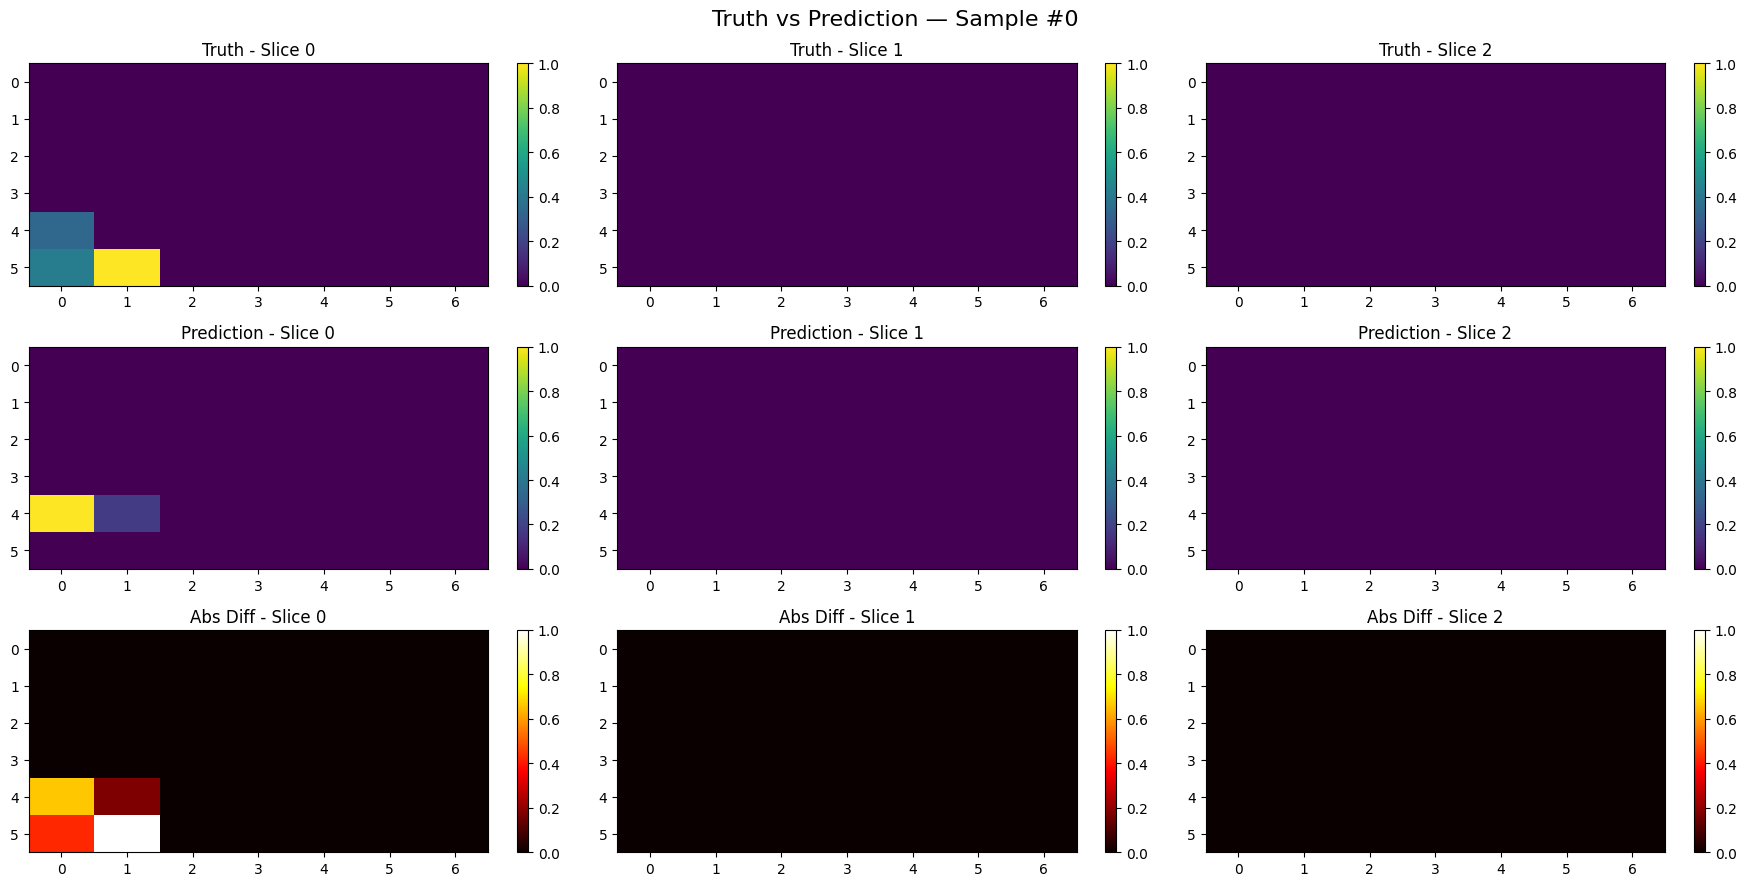

In [10]:
def plot_truth_vs_pred(truth, pred, sample_idx=0):
    fig, axes = plt.subplots(3, truth.shape[0], figsize=(18, 9))

    for i in range(truth.shape[0]):
        # Truth (fixed scale 0–1)
        im0 = axes[0, i].imshow(truth[i], cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[0, i].set_title(f'Truth - Slice {i}')
        plt.colorbar(im0, ax=axes[0, i])

        # Prediction (fixed scale 0–1)
        im1 = axes[1, i].imshow(pred[i], cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[1, i].set_title(f'Prediction - Slice {i}')
        plt.colorbar(im1, ax=axes[1, i])

        # Absolute Difference (fixed scale 0–1, or tweak if needed)
        im2 = axes[2, i].imshow(np.abs(truth[i] - pred[i]), cmap='hot', aspect='auto', vmin=0, vmax=1)
        axes[2, i].set_title(f'Abs Diff - Slice {i}')
        plt.colorbar(im2, ax=axes[2, i])

    plt.suptitle(f'Truth vs Prediction — Sample #{sample_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Get one prediction
sample_idx = 0
truth_sample = y[sample_idx]                                 
predicted = model.predict(X[sample_idx:sample_idx+1])[0]
print(X[sample_idx:sample_idx+1].shape, X[sample_idx:sample_idx+1])
plot_truth_vs_pred(y[sample_idx], predicted, sample_idx)

### Visualize 3D distributions of different events as a GIF

In [11]:
# Prepare data
X_vis = X[:10]
y_true = y[:10]
y_pred = model.predict(X_vis)

# Set up figure
fig = plt.figure(figsize=(12, 6))
ax_pred = fig.add_subplot(1, 2, 1, projection='3d')
ax_true = fig.add_subplot(1, 2, 2, projection='3d')

# Colormap
cmap = plt.get_cmap('magma')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(mappable, ax=[ax_pred, ax_true], shrink=0.6, pad=0.1).set_label('Normalized Value')

def update(frame):
    ax_pred.cla()
    ax_true.cla()

    pred = y_pred[frame]
    true = y_true[frame]

    pred_filled = pred > 0.01
    true_filled = true > 0.01

    pred_colors = cmap(norm(pred))
    true_colors = cmap(norm(true))

    ax_pred.voxels(pred_filled, facecolors=pred_colors, edgecolor='k', linewidth=0.2)
    ax_true.voxels(true_filled, facecolors=true_colors, edgecolor='k', linewidth=0.2)

    for ax, title in zip([ax_pred, ax_true], ['Prediction', 'Truth']):
        ax.set_xlim([0, y.shape[1]])
        ax.set_ylim([0, y.shape[2]])
        ax.set_zlim([0, y.shape[3]])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title(f'{title} - Event {frame}')

    return [ax_pred, ax_true]

ani = animation.FuncAnimation(fig, update, frames=len(X_vis), interval=1500, blit=False)

plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


## Show model structure

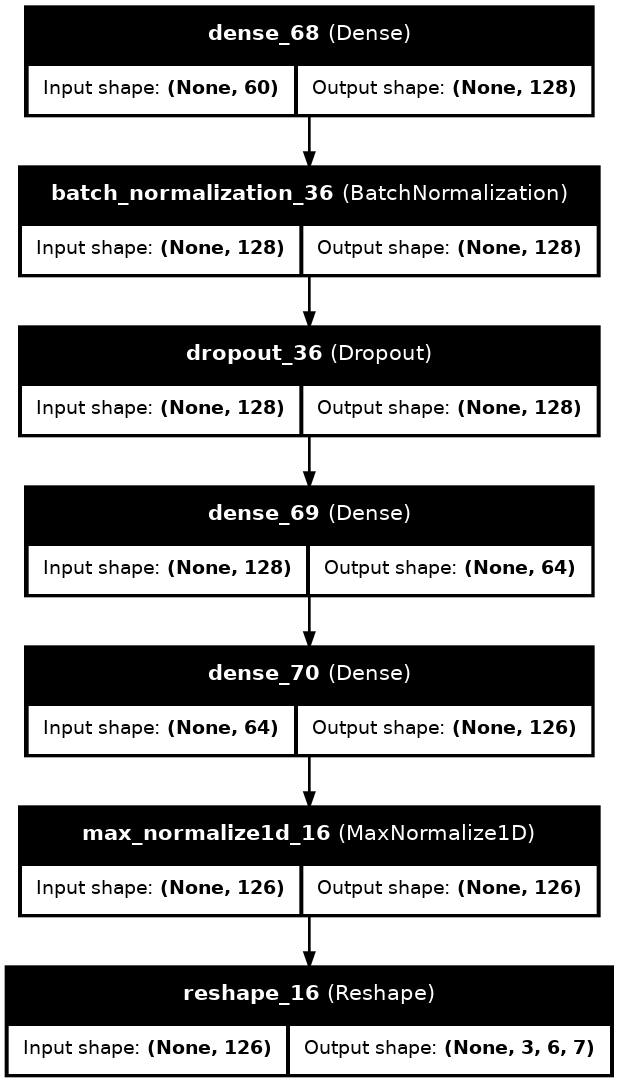

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    #to_file="model_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)
